## Imports

In [170]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torch import nn
import math
from torch.optim import Adam
from torch.utils.data import Dataset
from PIL import Image
import os

## Custom Dataset

In [173]:
class PairedImageDataset(Dataset):
    def __init__(self, dark_dir, bright_dir, transform=None):
        self.dark_dir = dark_dir
        self.bright_dir = bright_dir
        self.transform = transform
        self.filenames = sorted(os.listdir(dark_dir)) # assumung matching file names

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        dark_path = os.path.join(self.dark_dir, self.filenames[idx])
        bright_path = os.path.join(self.bright_dir, self.filenames[idx])

        dark_img = Image.open(dark_path).convert("RGB")
        bright_img = Image.open(bright_path).convert("RGB")

        if self.transform:
            dark_img = self.transform(dark_img)
            bright_img = self.transform(bright_img)

        return dark_img, bright_img

## Forwards Process

In [176]:
T = 300
gamma_schedule = torch.linspace(0.5, 3.0, T)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device='cpu'):
    gamma_t = get_index_from_list(gamma_schedule, t, x_0.shape)
    darkened = torch.clamp(x_0, min=1e-5) ** gamma_t # prevents zeros
    noise = torch.randn_like(x_0) * 0.03
    x_t = darkened + noise
    return x_t.to(device), noise.to(device)
                                                                                                                                                   

## Testing on Dataset

In [183]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # scales data to [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # scales data between [-1,1]
    ])

    dataset = PairedImageDataset(
        dark_dir = "./dataset/dark",
        bright_dir = "./dataset/bright",
        transform = transform
    )

    return dataset

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])

    # take first image of each batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

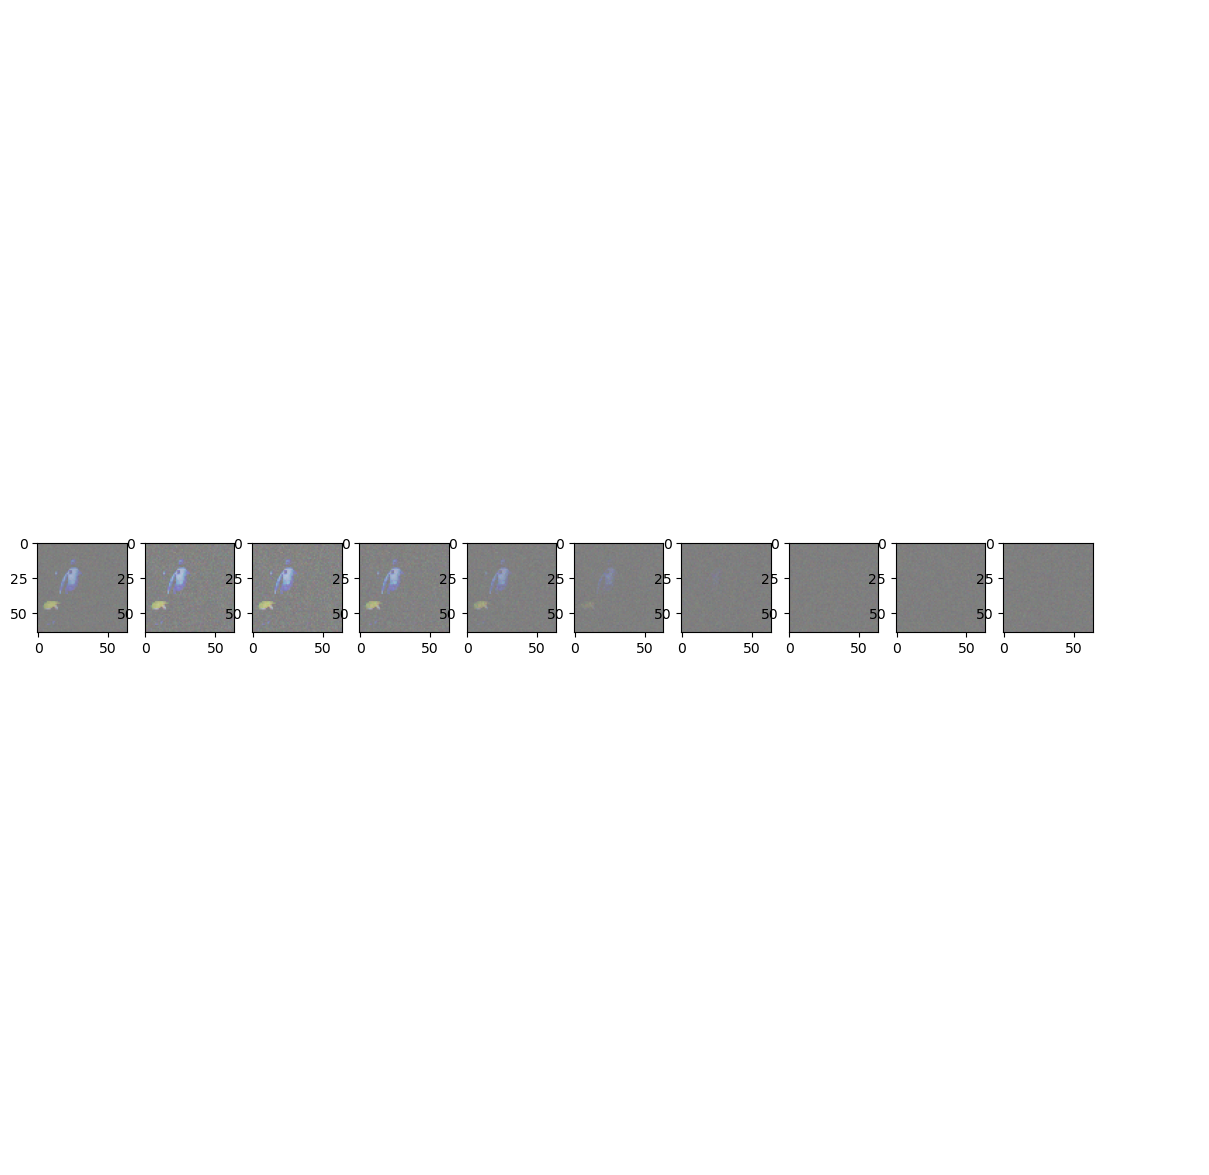

In [185]:
import matplotlib.pyplot as plt

# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T / num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, (idx // stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Backwards Process

In [187]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## The Loss

In [189]:
def get_loss(model, x_0, t):
    x_t, _  = forward_diffusion_sample(x_0, t, device)
    x_0_pred = model(x_t, t)
    return F.l1_loss(x_0_pred, x_0)

## Sampling

In [191]:
def sample_timestep(x, t, model):
    x_0_pred = model(x, t)
    if t > 0:
        gamma_t_minus_1 = get_index_from_list(gamma_schedule, t-1, x.shape)
        x_t_minus_1 = torch.clamp(x_0_pred, min=1e-5) ** gamma_t_minus_1
        noise = torch.randn_like(x) * 0.03
        return x_t_minus_1 + noise
    else:
        return x_0_pred

def sample_plot_image(model):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.zeros((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, model)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()
    

## Training

Starting training...
Epoch 0 starting...
Epoch 0, step 0
Epoch 0 | step 000 Loss: 0.8551804423332214 


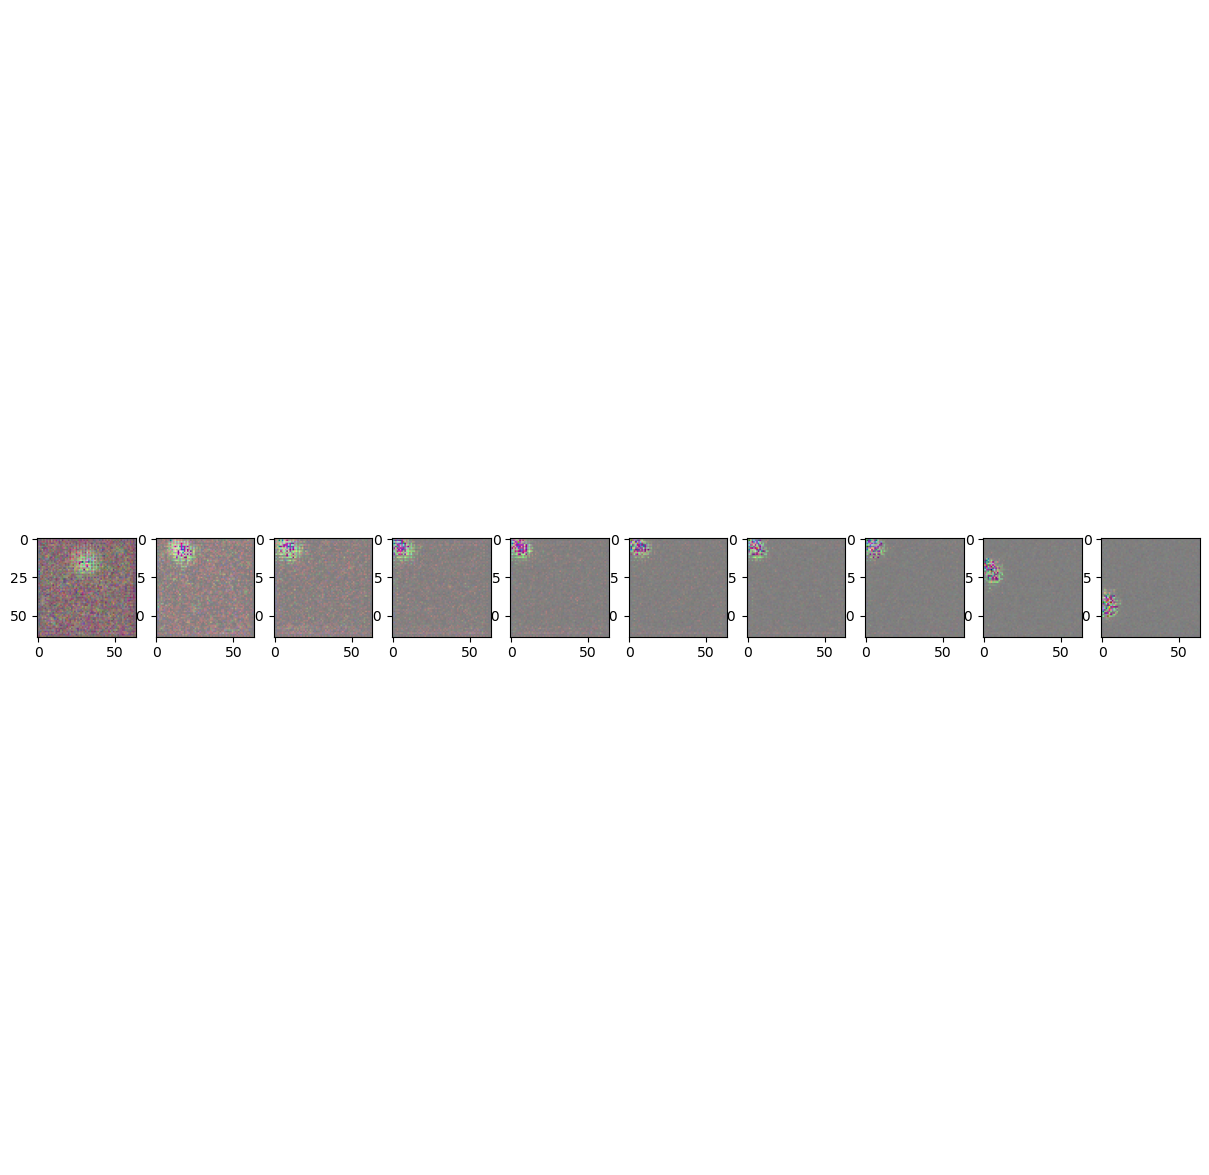

Epoch 0, step 1


KeyboardInterrupt: 

In [193]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 2

print("Starting training...")

for epoch in range(epochs):
    print(f"Epoch {epoch} starting...")
    model.train()
        
    for step, batch in enumerate(dataloader):
        print(f"Epoch {epoch}, step {step}")
        optimizer.zero_grad()

        x_0 = batch[0].to(device)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image(model)
        